In [1]:
#IMPORT PACKAGE
from PIL import Image
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.utils import img_to_array, load_img

In [2]:
#MAKE TRAIN AND VALIDATION DIRECTORY

#DON'T FORGET TO CHANGE THE DIRECTORY PATH
train_dir = "C:/Users/ACER/Documents/UNDIP/Dataset Tembakau resize/Training/"
train_rendah_dir = os.path.join(train_dir, "Rendah/")
train_sedang_dir = os.path.join(train_dir, "Sedang/")
train_tinggi_dir = os.path.join(train_dir, "Tinggi/")

#DON'T FORGET TO CHANGE THE DIRECTORY PATH
validation_dir = "C:/Users/ACER/Documents/UNDIP/Dataset Tembakau resize/Validation/"
validation_rendah_dir = os.path.join(validation_dir, "Rendah/")
validation_sedang_dir = os.path.join(validation_dir, "Sedang/")
validation_tinggi_dir = os.path.join(validation_dir, "Tinggi/")

Sample rendah image:


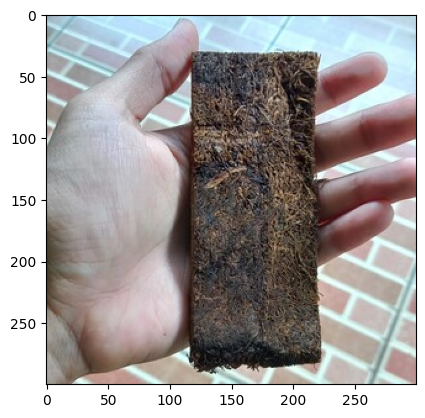

Sample sedang image:


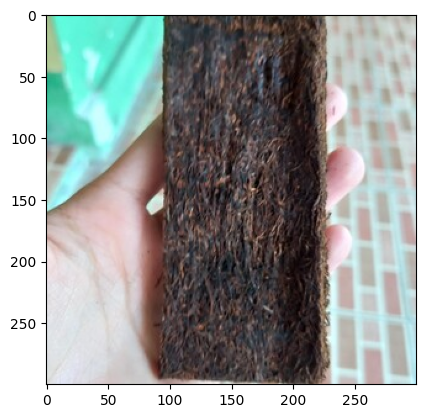

Sample tinggi image:


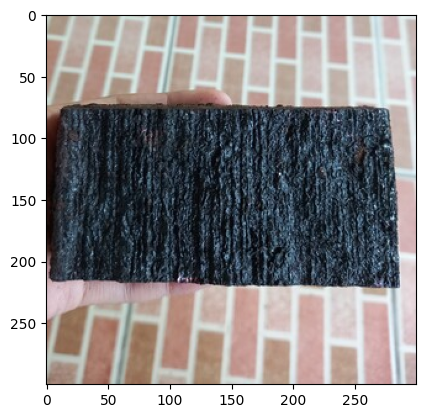

In [3]:
#SHOW TRAIN IMAGE

print("Sample rendah image:")
plt.imshow(load_img(f"{os.path.join(train_rendah_dir, os.listdir(train_rendah_dir)[0])}"))
plt.show()

print("Sample sedang image:")
plt.imshow(load_img(f"{os.path.join(train_sedang_dir, os.listdir(train_sedang_dir)[0])}"))
plt.show()

print("Sample tinggi image:")
plt.imshow(load_img(f"{os.path.join(train_tinggi_dir, os.listdir(train_tinggi_dir)[0])}"))
plt.show()

In [4]:
# Load the first example of a Garangan Tobacco low class
sample_image  = load_img(f"{os.path.join(train_rendah_dir, os.listdir(train_rendah_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")



Each image has shape: (300, 300, 3)
The maximum pixel value used is: 255.0


In [5]:
def image_generator(train_dir,validation_dir):
    # Instantiate the ImageDataGenerator class.
    # Remember to set the rescale argument.
    train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        target_size=(300, 300),
                                                        batch_size=32,
                                                        class_mode="categorical")
    
    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator( rescale = 1/255 )

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                 batch_size=32, 
                                                                 class_mode='categorical',
                                                                 target_size=(300, 300))
    ### END CODE HERE

    return train_generator,validation_generator

In [6]:
train_generator, validation_generator = image_generator(train_dir, validation_dir)

Found 135 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [7]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
#DON'T FORGET TO CHANGE THE DIRECTORY PATH
local_weights_file = 'C:/Users/ACER/Downloads/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
# create_pre_trained_model

def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.
  
  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file
    
  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (300, 300, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  ### END CODE HERE

  return pre_trained_model

In [9]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [11]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [12]:
# output_of_last_layer

def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model
  
  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from
    
  Returns:
    last_output: output of the model's last layer 
  """
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output

In [13]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 17, 17, 768)
last layer output:  Tensor("mixed7/Identity:0", shape=(None, 17, 17, 768), dtype=float32)


In [14]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'tensorflow.python.keras.engine.training.Model'>


In [30]:
def create_uncompiled_model():

    ### START CODE HERE
    
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)

    ### START CODE HERE

    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)       
    # Add a final sigmoid layer for classification
    x = x = layers.Dense  (3, activation='softmax')(x)         

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    ### END CODE HERE

    return model

In [32]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_generator)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [34]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule])
    
    return history

In [36]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_generator)

Epoch 1/100
5/5 [==============================] - 17s 3s/step - loss: 2.4869 - mae: 0.3996 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 15s 3s/step - loss: 1.0028 - mae: 0.3116 - lr: 1.1220e-04
Epoch 3/100
5/5 [==============================] - 15s 3s/step - loss: 1.2462 - mae: 0.3046 - lr: 1.2589e-04
Epoch 4/100
5/5 [==============================] - 17s 3s/step - loss: 1.0227 - mae: 0.2694 - lr: 1.4125e-04
Epoch 5/100
5/5 [==============================] - 15s 3s/step - loss: 0.7381 - mae: 0.2471 - lr: 1.5849e-04
Epoch 6/100
5/5 [==============================] - 15s 3s/step - loss: 0.5703 - mae: 0.2037 - lr: 1.7783e-04
Epoch 7/100
5/5 [==============================] - 15s 3s/step - loss: 0.6018 - mae: 0.2118 - lr: 1.9953e-04
Epoch 8/100
5/5 [==============================] - 17s 3s/step - loss: 0.5122 - mae: 0.1828 - lr: 2.2387e-04
Epoch 9/100
5/5 [==============================] - 18s 4s/step - loss: 0.5365 - mae: 0.1727 - lr: 2.5119e-04
Epoch 10/100
5/5 [=

(0.0001, 10.0, 0.0, 10.0)

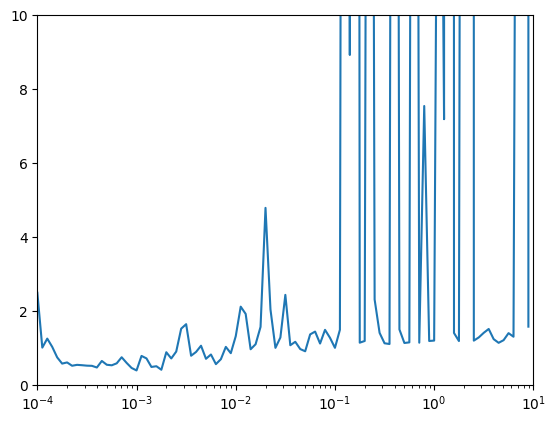

In [37]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [15]:
#create_final_model

def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model
  
  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model
    
  Returns:
    model: the combined model
  """
  # SAMAKAN MODEL FINAL DENGAN MODEL UNCOMPILED
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate
  x = layers.Dropout(0.2)(x)       
  # Add a final sigmoid layer for classification
  x = x = layers.Dense(3, activation='softmax')(x)         

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE
  
  return model

In [16]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 236,258,211 total parameters in this model.
There are 227,282,947 trainable parameters in this model.


In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    callbacks=callbacks,
                    verbose = 2)

Epoch 1/100
5/5 - 18s - loss: 0.7091 - accuracy: 0.7926 - val_loss: 2.3706 - val_accuracy: 0.6667
Epoch 2/100
5/5 - 19s - loss: 1.2586 - accuracy: 0.7778 - val_loss: 2.4230 - val_accuracy: 0.6944
Epoch 3/100
5/5 - 19s - loss: 0.6776 - accuracy: 0.7630 - val_loss: 1.4865 - val_accuracy: 0.6389
Epoch 4/100
5/5 - 18s - loss: 1.0366 - accuracy: 0.7778 - val_loss: 1.8838 - val_accuracy: 0.6944
Epoch 5/100
5/5 - 18s - loss: 0.9181 - accuracy: 0.7185 - val_loss: 1.9312 - val_accuracy: 0.7222
Epoch 6/100
5/5 - 19s - loss: 0.7505 - accuracy: 0.7556 - val_loss: 1.2495 - val_accuracy: 0.7500
Epoch 7/100
5/5 - 18s - loss: 0.3907 - accuracy: 0.8593 - val_loss: 1.7277 - val_accuracy: 0.7500
Epoch 8/100
5/5 - 21s - loss: 0.7129 - accuracy: 0.8222 - val_loss: 1.5778 - val_accuracy: 0.7222
Epoch 9/100
5/5 - 18s - loss: 0.3356 - accuracy: 0.8963 - val_loss: 0.7784 - val_accuracy: 0.7222
Epoch 10/100
5/5 - 21s - loss: 0.5031 - accuracy: 0.8444 - val_loss: 0.8920 - val_accuracy: 0.7500
Epoch 11/100
5/5 - 